In [1]:
%load_ext autotime

time: 346 µs (started: 2022-07-12 15:39:43 +08:00)


In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from tqdm.auto import tqdm

time: 1.34 s (started: 2022-07-12 15:39:43 +08:00)


In [3]:
from matplotlib.backends.backend_pdf import PdfPages

time: 87 ms (started: 2022-07-12 15:39:44 +08:00)


In [4]:
pd.set_option('display.max_rows', 200, 'display.max_columns', None)

time: 292 µs (started: 2022-07-12 15:39:45 +08:00)


In [5]:
all_rows = pd.option_context("display.max_rows", None)

time: 146 µs (started: 2022-07-12 15:39:45 +08:00)


In [6]:
months = pd.Series({m: i for i, m in enumerate("FGHJKMNQUVXZ")})

time: 3.79 ms (started: 2022-07-12 15:39:45 +08:00)


In [7]:
metadata = (
    pd.read_csv("contracts.csv")
    .dropna(subset=["Exch Symbol", "Currency", "Name", "Point Value", 
                    "Symbol", 'Futures Category'])
    .loc[lambda df: ~df.Symbol.isin(["TW1", "TW2"])]
    .rename(columns={"Symbol": "contract"})
    .set_index("contract")
)

metadata.loc[lambda df: df["Futures Category"].isin([
    'Indexes-Asian', 'Indexes-Australian',
    'Indexes-Canadian', 'Indexes-European',
    'Indexes-Global', 'Indexes-Indian Stocks',
    'Indexes-Mexican', 'Indexes-S. African', 'Indexes-S. American',
    'Indexes-U.S.',
]), 'Futures Category'] = "Equity Index"

metadata.loc[
    lambda df: df["Futures Category"].isin([
        'Govt Notes', 'Govt Bonds', 'Govt Rates', 'Interest Rates', 'Indexes-U.S. Bonds',
]), 'Futures Category'] = "Fixed Income"

metadata.loc["DX2", 'Futures Category'] = "FOREX"

time: 29.9 ms (started: 2022-07-12 15:39:45 +08:00)


In [8]:
names = metadata["Name"].str.lower()
point_values = metadata["Point Value"].str.lower()

time: 1.95 ms (started: 2022-07-12 15:39:45 +08:00)


In [9]:
multiplier = (
    point_values
    .loc[
        lambda df: (
            df.str.match("(usd|eur|\$|\d)")
            |
            df.str.contains("us dollar")
        )
    ]
    .str.extract("(\d+(?:[.]\d*)?|[.]\d+)", expand=False).astype(float)
    .mul(metadata["MinTick"])
    .rename("multiplier")
)
metadata["multiplier"] = multiplier

time: 7 ms (started: 2022-07-12 15:39:45 +08:00)


In [10]:
contract_blacklist = [
    # Duplicates of TF2
    "TF", "ER2",
    # Duplicate of ES
    "SP2",
    # Duplicate of TY
    "ZN",
    # Duplicate of TU
    "TU2",
    # Duplicate of LC
    "LC1",
    # Smaller version of CU
    "EX",
    # Smaller version of JY
    "JT",
    # Very illiquid
    "C4X", 
    # Strange rolling issues
    "EM",
]

time: 185 µs (started: 2022-07-12 15:39:45 +08:00)


In [11]:
contract_mask = (
    metadata.Currency.isin(["USD"])
    &
    metadata["Close Field Type"].eq("Settlement")
    &
    ~point_values.str.contains("contract")
    &
    ~point_values.str.contains("mwh")    
    &
    ~names.index.isin(contract_blacklist)
#     &
#     # Too big
#     ~names.index.isin(["PA2", "LGO", "US"])
    &
    (
        names.str.contains("combined session")
        |
        ~names.str.contains("session")
    )
    &
    ~names.str.contains("divided by 10")
)

time: 5.81 ms (started: 2022-07-12 15:39:45 +08:00)


In [12]:
dailies = (
    pd.read_parquet("csi_data.parquet").rename(columns={"symbol": "contract"})
    .set_index(["contract", "expiry", "date"])
)
dailies.close *= dailies.mult
dailies.volume /= dailies.mult
dailies.open_interest /= dailies.mult

time: 12.9 s (started: 2022-07-12 15:39:45 +08:00)


In [13]:
dailies.sort_index(inplace=True)
prev_close = dailies.groupby(["contract", "expiry"]).close.shift()
dailies["d_close"] = dailies.close.sub(prev_close).mul(metadata.multiplier)

time: 16.3 s (started: 2022-07-12 15:39:58 +08:00)


In [14]:
dailies["expiry_int"] = (
    dailies.eval("expiry").str.slice(0, 4).astype(int) * 12 + 
    dailies.eval("expiry").str.slice(4, 5).map(months)
)

time: 18.7 s (started: 2022-07-12 15:40:14 +08:00)


In [15]:
dailies["mod_month"] = dailies.eval(
    "expiry_int - (date.dt.year + (expiry_int.mod(12) < date.dt.month.sub(1))) * 12"
)

time: 3.25 s (started: 2022-07-12 15:40:33 +08:00)


In [16]:
dailies[["expiry_int", "mod_month"]] = dailies[["expiry_int", "mod_month"]].astype("Int64")

time: 7.19 s (started: 2022-07-12 15:40:36 +08:00)


In [17]:
dailies = dailies.query("mod_month.between(0, 11)").copy()

time: 3.15 s (started: 2022-07-12 15:40:43 +08:00)


In [18]:
dailies["mod_month"] = pd.Categorical.from_codes(dailies["mod_month"], months.index)

time: 30 ms (started: 2022-07-12 15:40:46 +08:00)


In [19]:
dailies = dailies.loc[lambda df: df.eval("contract").map(contract_mask).fillna(False)]

time: 2.38 s (started: 2022-07-12 15:40:46 +08:00)


In [20]:
contract_volumes = (
    dailies
    .assign(decade=lambda df: df.eval("date.dt.year.floordiv(10).mul(10)"))
    .groupby(["contract", "decade"])
    .agg({"volume": "mean", "d_close": "std"})
    .rename(columns={"d_close": "dollar_vol_per"})
    .reset_index()
)

time: 667 ms (started: 2022-07-12 15:40:49 +08:00)


In [21]:
contract_volumes["multiplier"] = contract_volumes.contract.map(metadata.multiplier)
contract_volumes["currency"] = contract_volumes.contract.map(metadata.Currency)
contract_volumes["category"] = contract_volumes.contract.map(metadata['Futures Category'])
contract_volumes["exchange"] = contract_volumes.contract.map(metadata.Exchange)
contract_volumes["exch_symbol"] = contract_volumes.contract.map(metadata['Exch Symbol'])
contract_volumes["name"] = contract_volumes.contract.map(metadata['Name'])
contract_volumes["dollar_vol"] = contract_volumes.eval("dollar_vol_per * volume")
contract_volumes["start_year"] = contract_volumes.contract.map(
    dailies.eval("date").groupby("contract").min().dt.year.astype("Int64")
)

time: 252 ms (started: 2022-07-12 15:40:49 +08:00)


In [22]:
shortlist = (
    contract_volumes    
    .query("category != 'Equity Index'")
#     .query("category != 'Fixed Income'")
    .query("start_year < 2000 & decade == 2010")
    .assign(cat_rank=lambda df: (
        df.groupby(["category", "decade"])
        .dollar_vol.rank(ascending=False)
        .fillna(0).astype(int)
    ))
    .sort_values(["cat_rank", "dollar_vol"], ascending=[True, False])
    .head(50)
#     .sort_values("dollar_vol_per", ascending=False)
    [["dollar_vol", "dollar_vol_per", "volume", "currency", "contract", "exchange", "exch_symbol",
      "category", "cat_rank", "name", "start_year"]]
    .reset_index(drop=True)
)
with all_rows:
    display(
        shortlist
        .style
        .format(subset=["dollar_vol", "dollar_vol_per", "volume"], formatter="{:.1e}")
        .set_properties(subset=["name"], **{'white-space': 'pre-wrap'})
    )

,dollar_vol,dollar_vol_per,volume,currency,contract,exchange,exch_symbol,category,cat_rank,name,start_year
0,1.6e+09,1.5e+04,1.1e+05,USD,US,CBT,US,Fixed Income,1,U.S. T-Bond (combined)-CBT,1977
1,5.1e+08,2.3e+04,2.2e+04,USD,LGO,ICE-EU,G,Energy,1,Low Sulphur Gasoil (combined),1981
2,2.2e+08,4.1e+03,5.4e+04,USD,CU,CME,Y2,FOREX,1,Euro (combined)-CME,1976
3,6.4e+07,7.3e+04,8.7e+02,USD,PA2,NYMEX,PA,Metals,1,Palladium (combined)-NYMEX,1977
4,6.4e+07,9.7e+02,6.6e+04,USD,C2,CBT,C,Grains & Oilseeds,1,Corn (combined)-CBT,1976
5,4.1e+07,5.9e+03,7.0e+03,USD,KC2,ICE-US,KC,Food & Fiber,1,Coffee (combined),1976
6,9.4e+06,1.0e+03,9.3e+03,USD,LC,CME,L2,Livestock & Meats,1,Live Cattle (combined)-CME,1976
7,5.6e+08,2.6e+03,2.2e+05,USD,FV,CBT,FV,Fixed Income,2,5-Year U.S. T-Note (combined)-CBT,1988
8,1.0e+08,3.5e+03,2.9e+04,USD,JY,CME,JY,FOREX,2,Japanese Yen (combined)-CME,1976
9,9.3e+07,1.2e+03,7.6e+04,USD,CL2,NYMEX,CL,Energy,2,Crude Oil (combined)-NYMEX,1983


time: 184 ms (started: 2022-07-12 15:40:50 +08:00)


In [23]:
top_ratio = (
    dailies
    .query("date > '2008'")
    .sort_values("volume")
    .groupby(["contract", "date"]).last()
    .groupby(["contract", "mod_month"]).volume.count()
)
top_ratio /= top_ratio.groupby("contract").transform("max")

time: 10.9 s (started: 2022-07-12 15:40:50 +08:00)


In [24]:
with PdfPages('expiry_volumes.pdf') as pdf:
    for contract_rank in tqdm(shortlist.index):

        title = "{contract_rank} - {contract} / {exch_symbol}({exchange}) / {name}".format(
            contract_rank=contract_rank, **shortlist.loc[contract_rank].to_dict()
        )

        plt.figure(dpi=100)

        ax = (
            top_ratio
            .loc[shortlist.contract[contract_rank]]
            .plot.bar(figsize=(8, 5), title=title)
        )
        
        ax.axhline(y=1/12, color="red")
        
        pdf.savefig()
        plt.close("all")        

  0%|          | 0/50 [00:00<?, ?it/s]

time: 2.15 s (started: 2022-07-12 15:41:01 +08:00)


In [25]:
volume_shares = (
    dailies.set_index("mod_month", append=True)    
    .reorder_levels(["contract", "date", "mod_month", "expiry"])
    .sort_index()
    .groupby(["contract", "date", "mod_month"], observed=True).open_interest.first()
#     .groupby(["contract", "mod_month"], observed=True).rolling(5).mean().reset_index([0, 1], drop=True)
    .pipe(lambda xs: xs / xs.groupby(["contract", "date"]).transform("sum"))
    .sort_index()
)

time: 3.8 s (started: 2022-07-12 15:41:03 +08:00)


In [26]:
with PdfPages('volume_share.pdf') as pdf:
    for contract_rank in tqdm(shortlist.index):
        title = "{contract_rank} - {contract} / {exch_symbol}({exchange}) / {name}".format(
            contract_rank=contract_rank, **shortlist.loc[contract_rank].to_dict()
        )
        
        plt.figure(dpi=100)

        (
            volume_shares
            .loc[shortlist.contract[contract_rank]].unstack("mod_month")
            .loc["2020":"2021"].plot(figsize=(8, 5), title=title)
        )
        
        pdf.savefig()
        plt.close("all")

  0%|          | 0/50 [00:00<?, ?it/s]

time: 4.11 s (started: 2022-07-12 15:41:07 +08:00)


In [27]:
dailies = (
    dailies
    .reset_index("expiry")
    .set_index("mod_month", append=True)
    .reorder_levels(["contract", "mod_month", "date"])
    .loc[top_ratio.gt(1/12)]
    .reset_index("mod_month")
    .set_index("expiry", append=True)
)

time: 7.19 s (started: 2022-07-12 15:41:11 +08:00)


In [28]:
volumes = dailies.volume.loc[lambda xs: xs > 0]
volumes /= volumes.groupby(["contract", "date"]).transform("sum")
volumes = volumes.sort_index().rename("volume_fraction")
volumes = volumes.groupby(["contract", "expiry"]).shift()

time: 1.02 s (started: 2022-07-12 15:41:18 +08:00)


In [29]:
front = (
    volumes
    .loc[lambda df: df.groupby(["contract", "expiry"]).cummax().gt(1/12)]
    .reset_index()
    .sort_values("expiry")
    .groupby(["contract", "date"])
    .first().set_index("expiry", append=True)
    .join(dailies)
    .reset_index("expiry")
)

time: 3.39 s (started: 2022-07-12 15:41:19 +08:00)


In [30]:
front["vol"] = (
    front
    .d_close.abs()
    .groupby("contract").rolling(180).mean()
    .reset_index(level=0, drop=True)
    .groupby("contract").shift()
)

time: 123 ms (started: 2022-07-12 15:41:22 +08:00)


In [31]:
with PdfPages('prices.pdf') as pdf:
    for contract in tqdm(shortlist.itertuples(), total=len(shortlist)):
        title = (f"{contract.Index} - {contract.contract} / "
                 f"{contract.exch_symbol}({contract.exchange}) / {contract.name}")
        plt.figure(dpi=100)

        (
            front.loc[contract.contract]
            .eval("d_close / vol").cumsum()
            .plot(figsize=(8, 5), title=title)
        )
        
        pdf.savefig()
        plt.close()        

  0%|          | 0/50 [00:00<?, ?it/s]

time: 3.14 s (started: 2022-07-12 15:41:23 +08:00)


In [32]:
cmat = (
    front.loc[shortlist.contract]
    .eval("d_close / vol")
    .unstack("contract")["2010":].corr()
)
# cmat_mask = cmat.notnull().mean().gt(0.9)
# cmat = cmat.loc[cmat_mask, cmat_mask]
with PdfPages('correlations.pdf') as pdf:
    for contract in tqdm(shortlist.contract):
        plt.figure(figsize=(8, 5), dpi=100)
        ax = (
            cmat[contract]
            .rename(metadata.index + " - " + metadata.Name)
            .iloc[lambda xs: np.argsort(xs.abs().values)[::-1]].dropna()
            .head(10)[::-1].plot.barh(title="Correlations", xlim=(-1, 1))
        )
        ax.axvline(0.5, color="pink")
        ax.axvline(-0.5, color="pink")
        ax.yaxis.set_label_coords(-1.9, .5)
        plt.subplots_adjust(left=0.6)
        pdf.savefig()
        plt.close("all")

<ipython-input-32-63d3e9068d11>:2: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  front.loc[shortlist.contract]


  0%|          | 0/50 [00:00<?, ?it/s]

time: 2.43 s (started: 2022-07-12 15:41:26 +08:00)


In [33]:
signals = []
for ndays in [200]:
    signals.append(
        front
        .eval("d_close / vol")
        .groupby("contract").cumsum()
        .pipe(lambda xs: (
            xs.groupby("contract").rolling(ndays).mean().reset_index(level=0, drop=True)
            .lt(xs)
        ))
        .groupby("contract").shift(fill_value=False)
        .pipe(lambda xs: xs * 2 - 1)
        .groupby("contract").rolling(30).mean().reset_index(level=0, drop=True)
    )
signal = pd.concat(signals, axis=1).mean(axis=1)

time: 264 ms (started: 2022-07-12 15:41:28 +08:00)


In [34]:
start_year = "1980"

rets = front.eval("d_close / vol * @signal")
pnl = rets.loc[shortlist.contract].groupby("date").sum()[start_year:]
bnh_rets = front.eval("d_close / vol")
leverage = 0.005
risk = leverage / pnl.std()

time: 183 ms (started: 2022-07-12 15:41:28 +08:00)


In [35]:
def plot_dd(c_pl, title):
    xlim=(c_pl.index[0], c_pl.index[-1])
    c_pl.plot(lw=1, color="black", title=title, xlim=xlim)
    plt.ylabel("Cumulative vol-normalized points")
    plt.fill_between(c_pl.index, c_pl, c_pl.cummax(), facecolor='red', alpha=0.5);
    

time: 260 µs (started: 2022-07-12 15:41:29 +08:00)


In [36]:
with PdfPages('returns.pdf') as pdf:
    c_pl = pnl.mul(risk).cumsum()
    plt.figure(figsize=(8, 5), dpi=100)
    plot_dd(c_pl, title="Trend")
    
    ax = (
        front.loc[shortlist.contract]
        .groupby("date").expiry.count()
        .cummax()
        .plot(secondary_y=True)
    )
    ax.set_ylabel("Contract Count", rotation=-90, labelpad=20)
    ax.set_ylim(0, None)

    pdf.savefig()
    plt.close("all")
    
    c_bnh = (
        bnh_rets.loc[shortlist.contract]
        .groupby("date").sum()
        [start_year:].mul(risk).cumsum()
    )
    plt.figure(figsize=(8, 5), dpi=100)
    plot_dd(c_bnh, title="Buy and Hold")

    pdf.savefig()
    plt.close("all")
    
    for contract in tqdm(shortlist.itertuples(), total=len(shortlist)):
        title = (f"{contract.Index} - {contract.contract} / "
                 f"{contract.exch_symbol}({contract.exchange}) / {contract.name}")
        
        all_rets = pd.DataFrame({
            "trend": rets.loc[contract.contract],
            "buy and hold": bnh_rets.loc[contract.contract],
        })
        
        plt.figure(dpi=100)
        
        ax = signal.loc[contract.contract].plot(secondary_y=True, color="grey", alpha=0.3)
        ax.set_ylabel("Signal", rotation=-90)
#         ax.set_ylim(-0.2, 1.3)
        
        ax = (
            all_rets.loc[start_year:].cumsum()
            .plot(
                figsize=(8, 5), 
                title=title,
                xlim=(pnl.index[0], pnl.index[-1]),
                ax=ax,
            )
        )
        ax.left_ax.set_ylabel("Cumulative vol-normalized points")
        ax.legend(*ax.left_ax.get_legend_handles_labels(), loc="upper left")
                
        pdf.savefig()
        plt.close("all")

  0%|          | 0/50 [00:00<?, ?it/s]

time: 6.98 s (started: 2022-07-12 15:41:29 +08:00)


In [37]:
all_rets_by_category = (
    pd.DataFrame({
        "trend": rets,
        "buy and hold": bnh_rets,
    })
    .loc[shortlist.contract]
)
all_rets_by_category = (
    all_rets_by_category
    .groupby([
        all_rets_by_category.index.get_level_values("contract").map(metadata["Futures Category"]).rename("category"),
        "date"
    ]).sum()
)

time: 205 ms (started: 2022-07-12 15:41:36 +08:00)


In [38]:
with PdfPages('returns_by_category.pdf') as pdf:
    for category in tqdm(all_rets_by_category.index.get_level_values("category").drop_duplicates()):
        plt.figure(figsize=(8, 5), dpi=100)
        plot_dd(all_rets_by_category.loc[category]["trend"].loc[start_year:].cumsum(), 
                title=f"{category} trend")
        pdf.savefig()
        plt.close("all")
        
        plt.figure(figsize=(8, 5), dpi=100)
        plot_dd(all_rets_by_category.loc[category]["buy and hold"].loc[start_year:].cumsum(), 
                title=f"{category} buy and hold")
        pdf.savefig()
        plt.close("all")

  0%|          | 0/7 [00:00<?, ?it/s]

time: 1.36 s (started: 2022-07-12 15:41:36 +08:00)


In [39]:
decade = (pnl.index.get_level_values("date").year // 5) * 5
by_period = {}
legend = []
for _, pnl0 in pnl.groupby(decade):
    yr0 = pnl0.index.year[0]
    pnl0.index = ((pnl0.index - pd.Timestamp(yr0, 1, 1)) / pd.Timedelta(days=1)).astype(int)
    by_period[yr0] = pnl0
by_period = pd.DataFrame(by_period)

time: 8.32 ms (started: 2022-07-12 15:41:37 +08:00)


<AxesSubplot:xlabel='date'>

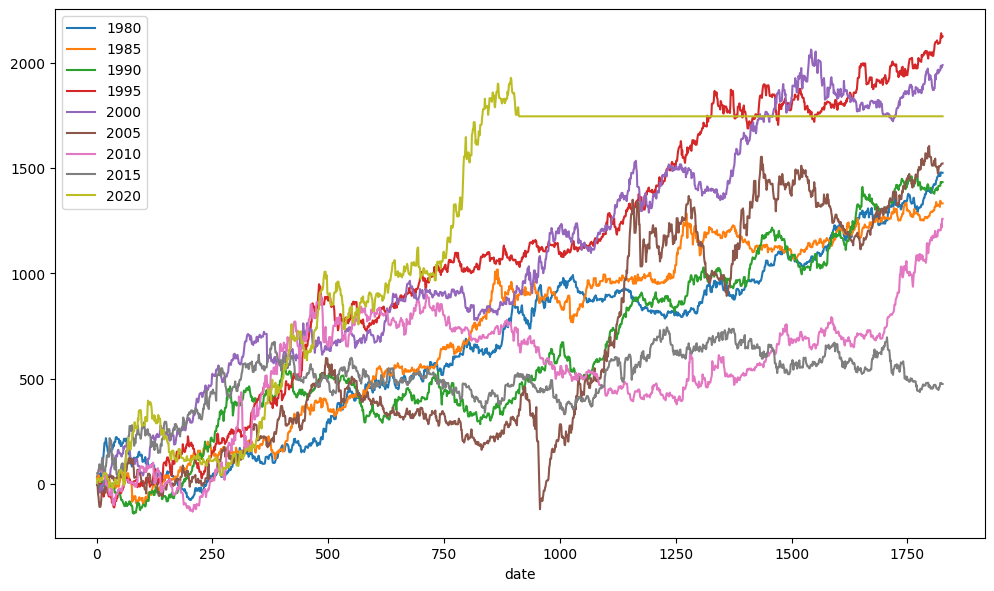

time: 145 ms (started: 2022-07-12 15:41:37 +08:00)


In [40]:
plt.figure(figsize=(12, 7), dpi=100)
by_period.cumsum().fillna(method="ffill").plot(ax=plt.gca())

In [41]:
by_period.apply(lambda xs: xs.mean() / xs.std() * 250**0.5)

1980    1.517241
1985    1.190442
1990    1.272198
1995    1.642763
2000    1.373920
2005    0.822230
2010    0.807198
2015    0.351164
2020    1.816641
dtype: float64

time: 3.76 ms (started: 2022-07-12 15:41:37 +08:00)


In [42]:
ES_signal = (
    front.loc["ES"].eval("d_close / vol").cumsum()
    .pipe(lambda xs: xs.rolling(200).mean().lt(xs))
    .shift(fill_value=False)
    .rolling(90).mean()
)
ES_position = ES_signal.div(front.vol["ES"])
ES_ret = ES_position.mul(front.d_close["ES"])
ES_risk = leverage / ES_ret.std()

time: 273 ms (started: 2022-07-12 15:41:37 +08:00)


In [43]:
(
    pd.concat([
        ES_ret.rename("ES"), 
        pnl.rename("Portfolio"),
    ], axis=1)
    .dropna()
    .groupby(pd.Grouper(freq="5Y"))
    .corr()
    .unstack().iloc[:, 1]
    .rename(lambda xs: xs.year)
)

date
1983   -0.037317
1988    0.019602
1993   -0.040498
1998   -0.039925
2003   -0.059057
2008    0.088900
2013    0.187038
2018    0.009009
2023   -0.085633
Name: (ES, Portfolio), dtype: float64

time: 10.1 ms (started: 2022-07-12 15:41:38 +08:00)


<AxesSubplot:title={'center':'Gross Sharpe'}, xlabel='date'>

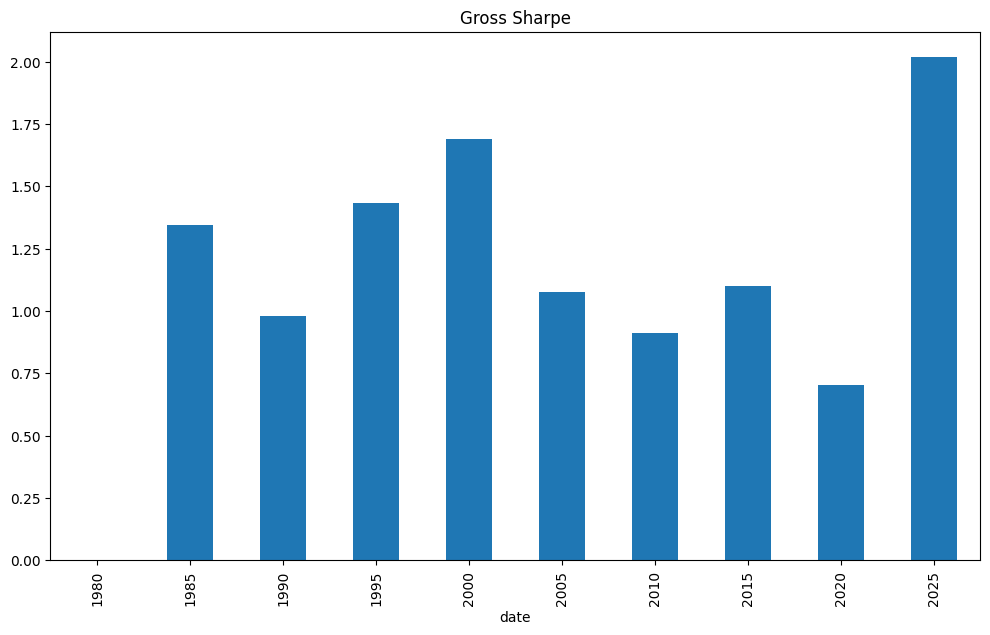

time: 86.1 ms (started: 2022-07-12 15:41:38 +08:00)


In [44]:
plt.figure(figsize=(12, 7), dpi=100)
(
    (ES_ret.mul(ES_risk) + pnl.mul(risk))
    .groupby(pd.Grouper(freq="5Y"))
    .apply(lambda xs: xs.mean() / xs.std() * 250**0.5)
    .rename(lambda xs: xs.year)    
    .plot.bar(title="Gross Sharpe")
)

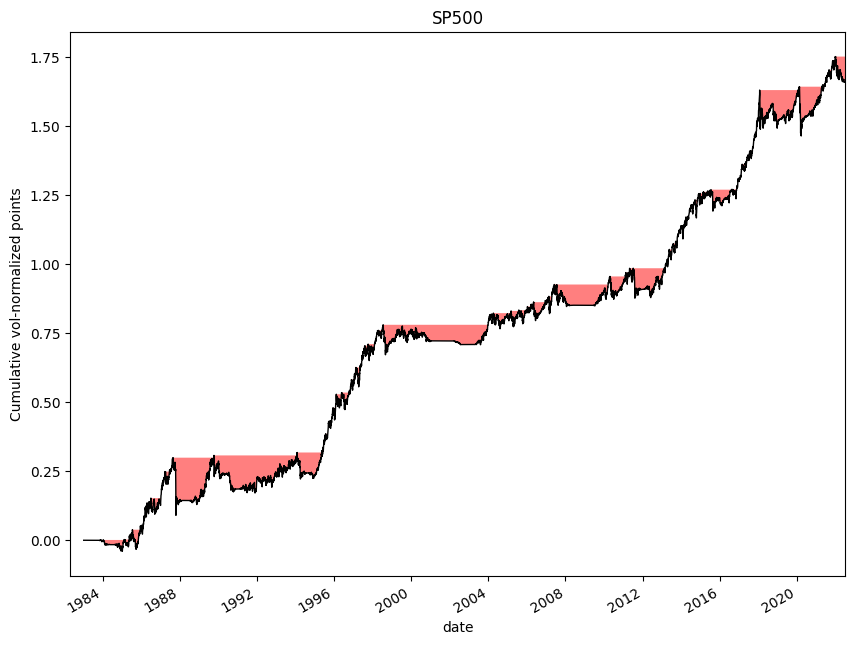

time: 136 ms (started: 2022-07-12 15:41:38 +08:00)


In [45]:
plt.figure(figsize=(10, 8), dpi=100)
plot_dd(ES_ret.mul(ES_risk).cumsum(), "SP500")

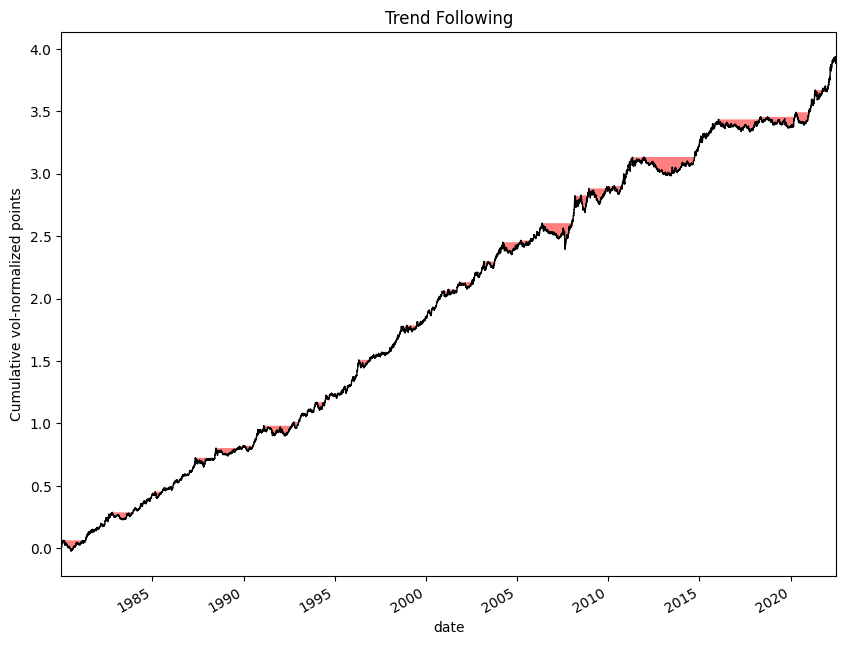

time: 131 ms (started: 2022-07-12 15:41:38 +08:00)


In [46]:
plt.figure(figsize=(10, 8), dpi=100)
plot_dd(pnl.mul(risk).cumsum(), "Trend Following")

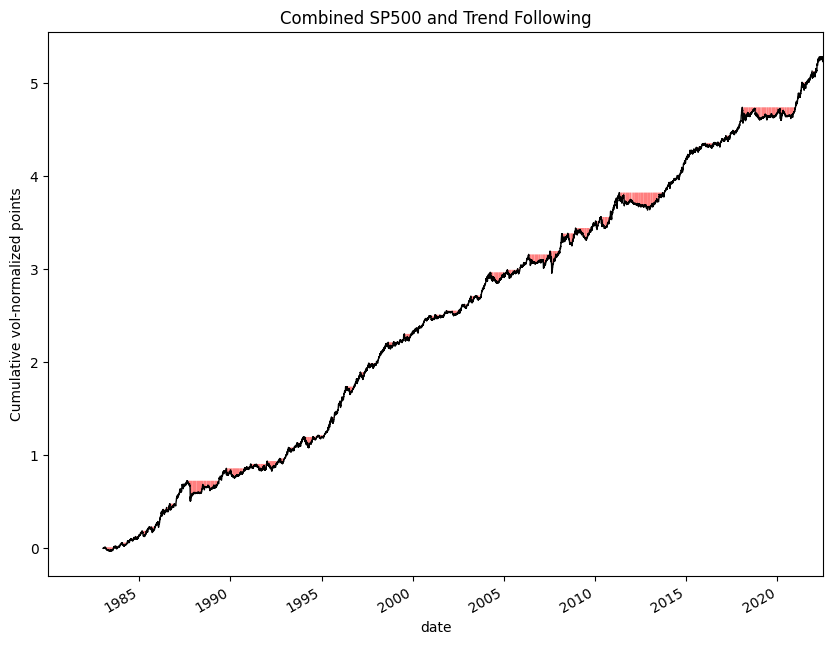

time: 144 ms (started: 2022-07-12 15:41:38 +08:00)


In [47]:
plt.figure(figsize=(10, 8), dpi=100)
plot_dd((ES_ret.mul(ES_risk) + pnl.mul(risk)).cumsum(), "Combined SP500 and Trend Following")

In [48]:
# index from https://www.iasg.com/en/indexes/trend-following-index/historical-data
iasg_index = (
    pd.read_html("tf_index.html")[0].set_index("Year")
    .rename_axis(columns="Month").drop(["YTD", "DD"], axis=1)
    .stack("Month").rename("return").reset_index()
    .assign(ts=lambda df: pd.to_datetime(
        df["Year"].astype(str) + df["Month"], format="%Y%b"
    ))
    .set_index("ts")["return"]
    .sort_index()
    .transform(lambda xs: xs / xs.abs().rolling(12).mean())
)

comparison = pd.concat([
    iasg_index.dropna().groupby(pd.Grouper(freq="M")).sum()[1:].rename("index"),
    pnl.groupby(pd.Grouper(freq="M")).sum()[1:].rename("ours")
], axis=1).dropna()

(
    comparison
    .groupby(lambda xs: (xs.year // 10) * 10)
    .corr().unstack().iloc[:, 1]
)

1980    0.563142
1990    0.493373
2000    0.642948
2010    0.593543
2020    0.716126
Name: (index, ours), dtype: float64

time: 97.1 ms (started: 2022-07-12 15:41:38 +08:00)


<AxesSubplot:title={'center':'ES returns'}, xlabel='date'>

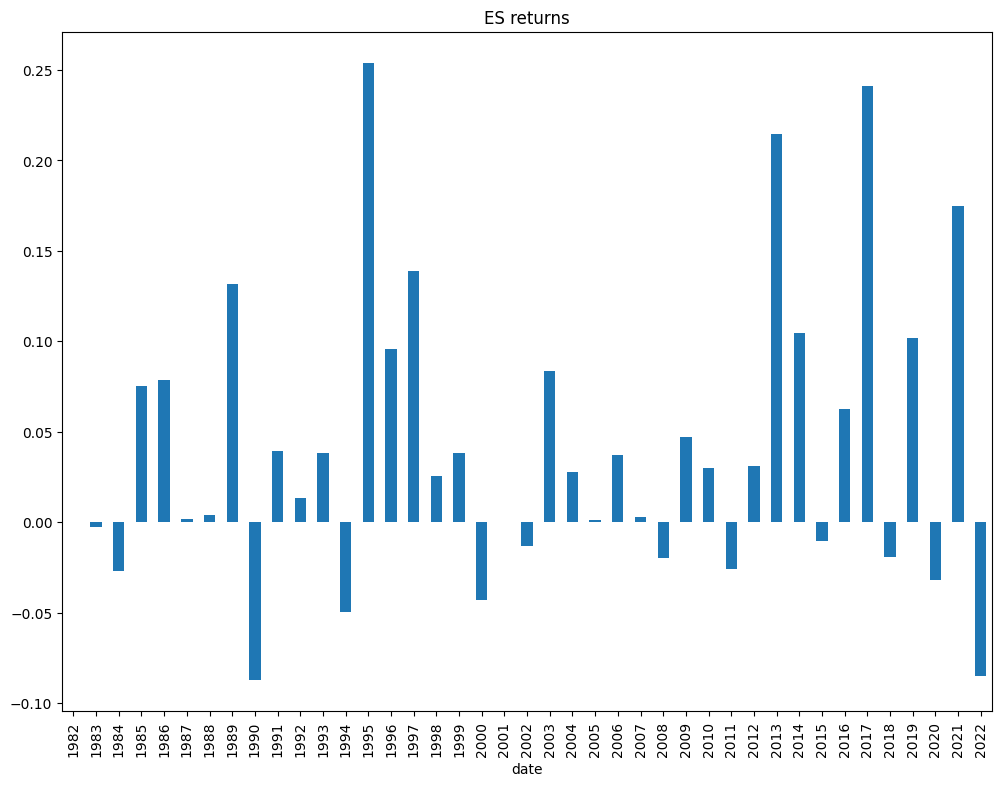

time: 182 ms (started: 2022-07-12 15:41:38 +08:00)


In [49]:
plt.figure(figsize=(12, 9), dpi=100)
(
    ES_ret.mul(ES_risk).add(1)
    .groupby(pd.Grouper(freq="Y")).prod().sub(1)
    .rename(lambda xs: xs.year)
#     .pipe(lambda xs: np.exp(np.log(xs + 1).mean()) - 1)
    .plot.bar(title="ES returns")
)

<AxesSubplot:title={'center':'TF returns'}, xlabel='date'>

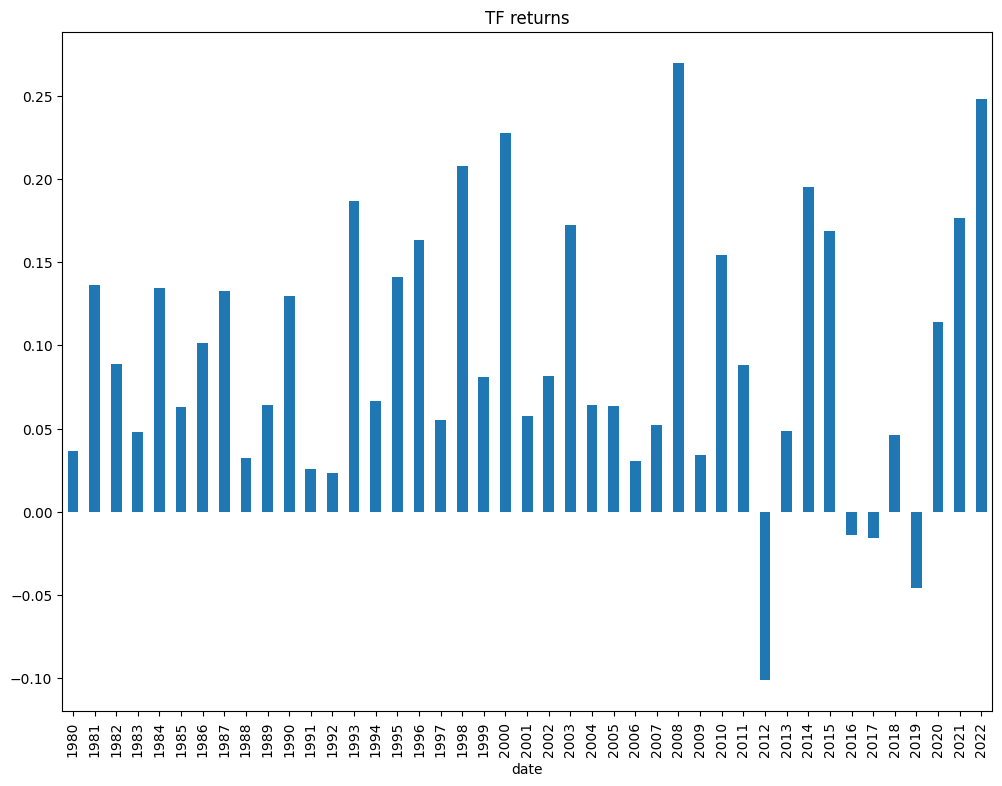

time: 184 ms (started: 2022-07-12 15:41:38 +08:00)


In [50]:
plt.figure(figsize=(12, 9), dpi=100)
(
    pnl
    .mul(risk).add(1)
    .groupby(pd.Grouper(freq="Y")).prod().sub(1)
    .rename(lambda xs: xs.year)
#     .pipe(lambda xs: np.exp(np.log(xs + 1).mean()) - 1)
    .plot.bar(title="TF returns")
)

<AxesSubplot:title={'center':'Total returns'}, xlabel='date'>

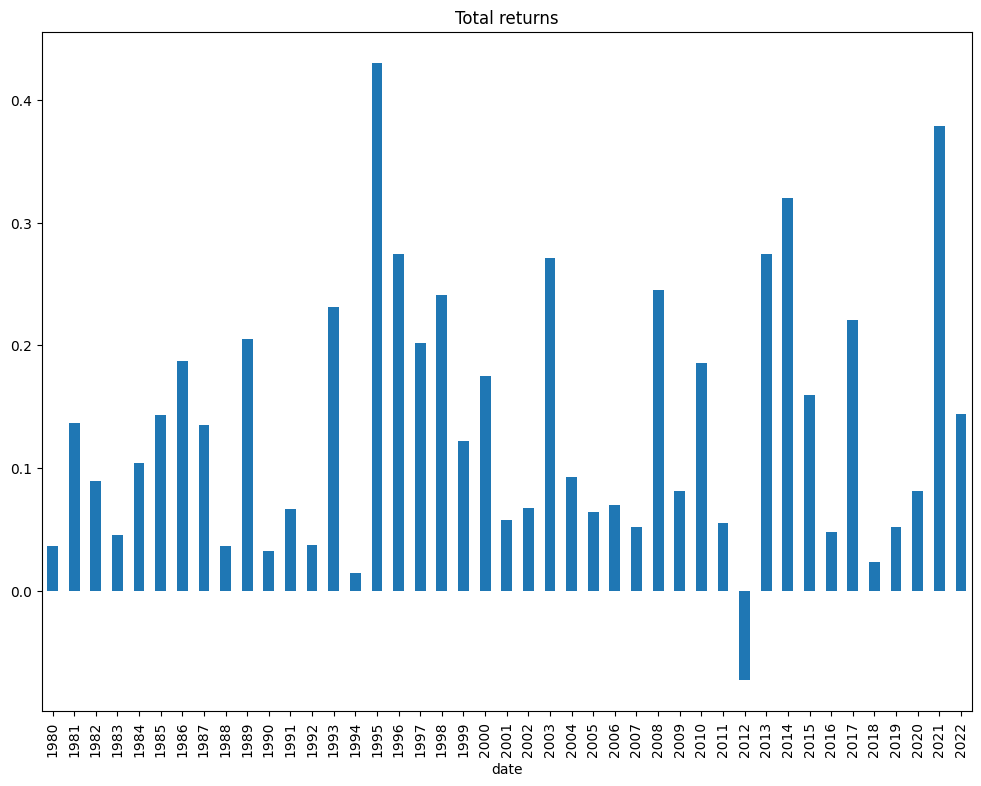

time: 171 ms (started: 2022-07-12 15:41:39 +08:00)


In [51]:
plt.figure(figsize=(12, 9), dpi=100)
(
    ES_ret.mul(ES_risk).add(pnl.mul(risk), fill_value=0).add(1)
    .groupby(pd.Grouper(freq="Y")).prod().sub(1)
    .rename(lambda xs: xs.year)
#     .pipe(lambda xs: np.exp(np.log(xs + 1).mean()) - 1)
    .plot.bar(title="Total returns")
)

<AxesSubplot:title={'center':'Drawdowns'}, xlabel='date'>

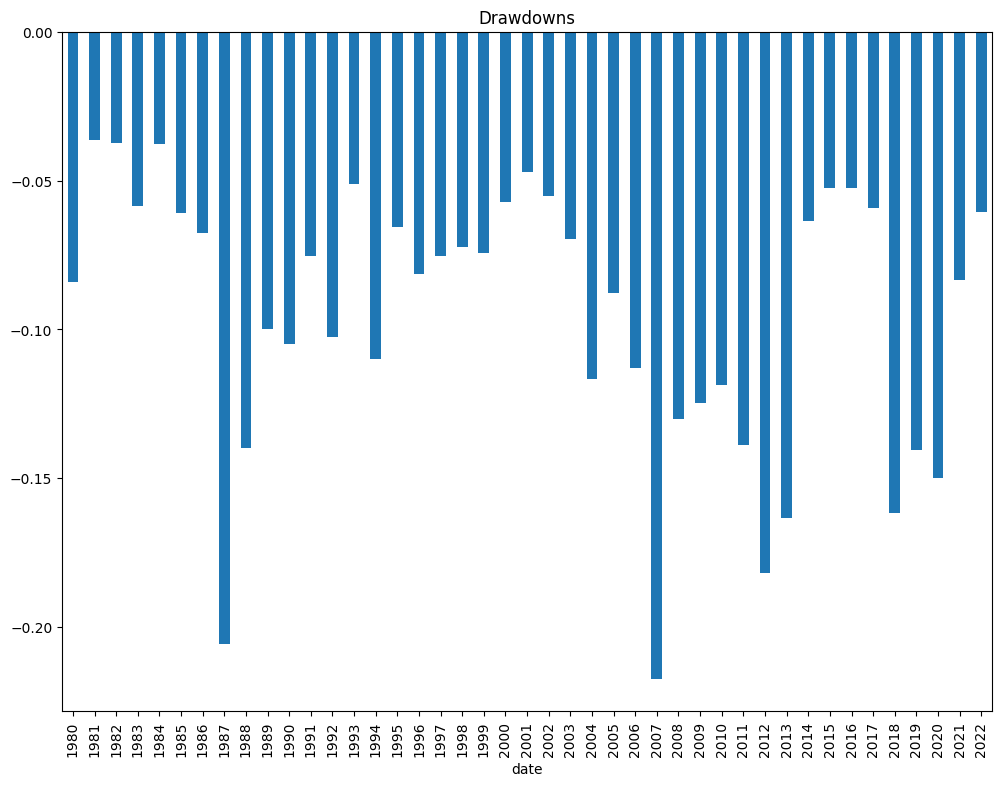

time: 174 ms (started: 2022-07-12 15:41:39 +08:00)


In [52]:
plt.figure(figsize=(12, 9), dpi=100)
(
    ES_ret.mul(ES_risk).add(pnl.mul(risk), fill_value=0)
    .add(1).cumprod()
    .pipe(lambda xs: xs.div(xs.cummax()) - 1)
    .groupby(pd.Grouper(freq="Y")).min()
    .rename(lambda xs: xs.year)
    .plot.bar(title="Drawdowns")
)

In [53]:
contracts_per_dollar =(
    signal.div(front.vol)
    .loc[shortlist.contract]
    .mul(risk).dropna()
)
trades_per_dollar = (
    contracts_per_dollar
    .groupby(["contract", front.expiry]).diff()
    .fillna(contracts_per_dollar)
)
gross_per_dollar = (
    contracts_per_dollar
    .mul(front.d_close.loc[shortlist.contract])
)

time: 5.59 s (started: 2022-07-12 15:41:39 +08:00)


<AxesSubplot:title={'center':'Gross profit per roundtrip'}>

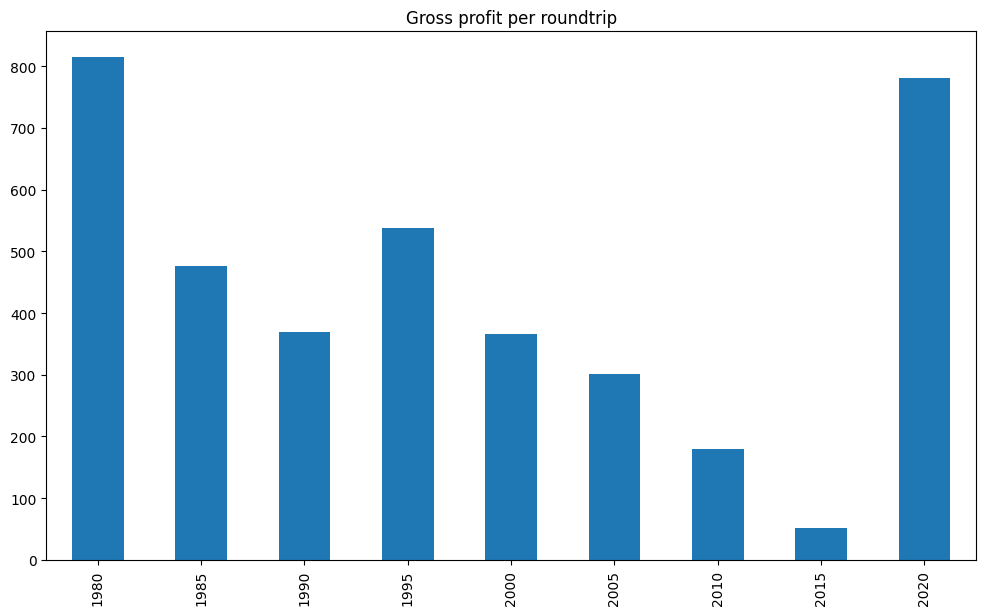

time: 2.51 s (started: 2022-07-12 15:41:45 +08:00)


In [54]:
plt.figure(figsize=(12, 7), dpi=100)
(
    pd.concat([
        contracts_per_dollar.rename("contracts"),
        trades_per_dollar.abs().rename("trades"),
        gross_per_dollar.rename("gross"),
    ], axis=1)
    .query("date.dt.year >= 1980")
    .groupby(lambda xs: xs[1].year // 5 * 5)
    .sum()
    .pipe(lambda df: df["gross"] / df["trades"] * 2)
    .plot.bar(title="Gross profit per roundtrip")
)

In [55]:
balance = 1e6
actual_positions = contracts_per_dollar.mul(balance).round()

time: 2.34 ms (started: 2022-07-12 15:41:47 +08:00)


In [56]:
# with PdfPages('actual_positions.pdf') as pdf:
#     for date0, row in tqdm(
#         actual_positions.unstack("contract")
#         .fillna(method="ffill").dropna()
#         .sort_index()[start_year:]
#         .sample(10).sort_index().iterrows()
#     ):
#         plt.figure(figsize=(8, len(row) * 0.25))
#         row.rename(index=metadata.Name).plot.barh(title=str(date0.date()))
#         plt.tight_layout()
#         pdf.savefig()
#         plt.close("all")

time: 120 µs (started: 2022-07-12 15:41:47 +08:00)


In [57]:
actual_trades = (
    actual_positions
    .groupby(["contract", front.expiry]).diff()
    .fillna(actual_positions)
)
actual_trades_wo_rolls = (
    actual_positions
    .groupby(["contract"]).diff()
    .fillna(actual_positions)
)

time: 2.79 s (started: 2022-07-12 15:41:47 +08:00)


In [58]:
(
    actual_trades.loc[lambda xs: xs.ne(0)]
    .reorder_levels([1, 0])
    .sort_index()
    .unstack("contract")
    .tail(20)
    .loc[:, lambda xs: xs.notnull().any()]
    .sort_index(axis=1)
    .rename(lambda xs: xs.date())
    .style
    .format("{:.0f}", na_rep="")
)

contract,BP,CC2,ED,FF,MP,SB2,SM2,TU,TY
date,,,,,,,,,
2022-05-06,,,,,-1,,,,
2022-05-10,,-1,,,,,,,
2022-05-12,,,,,1,,,,
2022-05-13,,,,,,,,,1
2022-05-16,,,,,-1,,1,,
2022-05-17,,,,,1,,,,
2022-05-18,,,,,-1,,,,
2022-05-19,,,,-1,,,,,
2022-06-01,,,,13,,,,,


time: 12.3 ms (started: 2022-07-12 15:41:50 +08:00)


In [59]:
contracts_traded = actual_trades.abs().groupby("date").sum()
contracts_traded_wo_rolls = actual_trades_wo_rolls.abs().groupby("date").sum()

time: 19.8 ms (started: 2022-07-12 15:41:50 +08:00)


In [60]:
actual_returns = (
    actual_positions
    .mul(front.d_close.loc[shortlist.contract])
    .groupby("date").sum()
)

time: 2.56 s (started: 2022-07-12 15:41:50 +08:00)


<AxesSubplot:xlabel='date'>

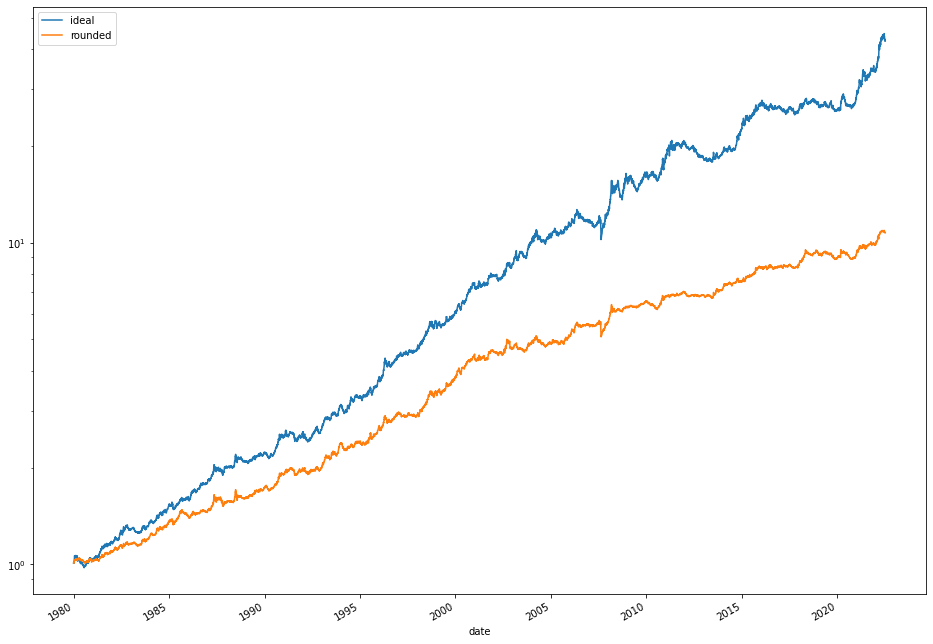

time: 336 ms (started: 2022-07-12 15:41:52 +08:00)


In [61]:
(
    pd.DataFrame({
        "ideal": pnl.mul(risk),
        "rounded": actual_returns.div(balance),
    })[start_year:]
    .add(1)
    .cumprod()
    .plot(logy=True, figsize=(16, 12))
)

<AxesSubplot:xlabel='date'>

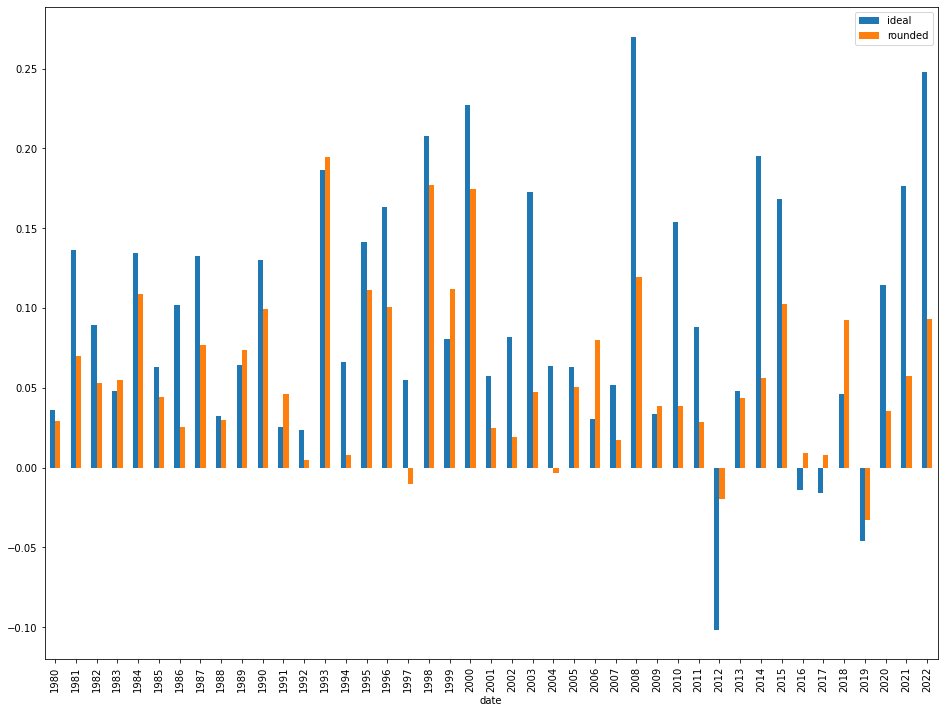

time: 240 ms (started: 2022-07-12 15:41:53 +08:00)


In [62]:
(    
    pd.DataFrame({
        "ideal": pnl.mul(risk),
        "rounded": actual_returns.div(balance),
    })
    [start_year:]
    .add(1).groupby(pd.Grouper(freq="Y")).prod().sub(1)
    .rename(lambda xs: xs.year)
    .plot.bar(figsize=(16, 12))
)